In [1]:
#Using Hyperparameters to predict horse health
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
!pip install missingno
!pip install yellowbrick
!pip install numba --upgrade
!pip install folium
!pip install haversine
#!pip install xgboost
!pip install optuna
!pip install catboost
!pip install category_encoders
!pip install imblearn
import missingno as msno
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from copy import deepcopy
from functools import partial
from itertools import combinations
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium
#from haversine import haversine
import random
from random import uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
import statsmodels.api as sm
import math
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
import xgboost as xgb
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.ensemble import HistGradientBoostingRegressor,ExtraTreesRegressor,GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoost, CatBoostRegressor,CatBoostClassifier
from catboost import Pool
from sklearn.neighbors import KNeighborsRegressor
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/eb/61/db566ad7cd3f7e9191ec744f25cf6455e8d91732ad70be8fcdd203a48dab/numba-0.58.1-cp39-cp39-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.1 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: numba
    Found existing installation: numba 0.58.0
    Uninstalling numba-0.58.0:
      Successfully uninstalled numba-0.58.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
data=pd.read_csv("sample_submission.csv")

orig_train=pd.read_csv("train.csv")
orig_test=pd.read_csv("test.csv")

orig_train=orig_train.rename(columns={"Id":"id"})
orig_test=orig_test.rename(columns={"Id":"id"})

data.head()

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,lived
4,1239,lived


In [3]:
table = PrettyTable()

table.field_names = ['Column Name', 'Data Type', "Mising %", 'Original Missing %']
for column in data.columns:
    data_type = str(data[column].dtype)
    non_null_count_train= np.round(100-orig_train[column].count()/orig_train.shape[0]*100,1)
    non_null_count_data = np.round(100-data[column].count()/data.shape[0]*100,1)
    table.add_row([column, data_type,non_null_count_data, non_null_count_train])
print(table)

+-------------+-----------+----------+--------------------+
| Column Name | Data Type | Mising % | Original Missing % |
+-------------+-----------+----------+--------------------+
|      id     |   int64   |   0.0    |        0.0         |
|   outcome   |   object  |   0.0    |        0.0         |
+-------------+-----------+----------+--------------------+


In [4]:
orig_train=orig_train.dropna()
data=pd.get_dummies(orig_train,drop_first=False)
data_pure=data.copy()
data.head()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3,surgery_no,surgery_yes,age_adult,age_young,temp_of_extremities_None,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm,peripheral_pulse_None,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,capillary_refill_time_3,capillary_refill_time_None,capillary_refill_time_less_3_sec,capillary_refill_time_more_3_sec,pain_None,pain_alert,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_severe_pain,pain_slight,peristalsis_None,peristalsis_absent,peristalsis_distend_small,peristalsis_hypermotile,peristalsis_hypomotile,peristalsis_normal,abdominal_distention_None,abdominal_distention_moderate,abdominal_distention_none,abdominal_distention_severe,abdominal_distention_slight,nasogastric_tube_None,nasogastric_tube_none,nasogastric_tube_significant,nasogastric_tube_slight,nasogastric_reflux_None,nasogastric_reflux_less_1_liter,nasogastric_reflux_more_1_liter,nasogastric_reflux_none,nasogastric_reflux_slight,rectal_exam_feces_None,rectal_exam_feces_absent,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,rectal_exam_feces_serosanguious,abdomen_None,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdomo_appearance_None,abdomo_appearance_clear,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,surgical_lesion_no,surgical_lesion_yes,cp_data_no,cp_data_yes,outcome_died,outcome_euthanized,outcome_lived
0,0,530001,38.1,132.0,24.0,6.5,57.0,8.5,3.4,2209,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0
1,1,533836,37.5,88.0,12.0,2.0,33.0,64.0,2.0,2208,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0
2,2,529812,38.3,120.0,28.0,3.5,37.0,6.4,3.4,5124,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1
3,3,5262541,37.1,72.0,30.0,2.0,53.0,7.0,3.9,2208,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1
4,4,5299629,38.0,52.0,48.0,7.0,47.0,7.3,2.6,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1


In [5]:
data.drop(['outcome_euthanized','outcome_died'],axis=1)
data.drop(data.columns[[84, 85]], axis=1, inplace=True)
data.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3,surgery_no,surgery_yes,age_adult,age_young,temp_of_extremities_None,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm,peripheral_pulse_None,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,capillary_refill_time_3,capillary_refill_time_None,capillary_refill_time_less_3_sec,capillary_refill_time_more_3_sec,pain_None,pain_alert,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_severe_pain,pain_slight,peristalsis_None,peristalsis_absent,peristalsis_distend_small,peristalsis_hypermotile,peristalsis_hypomotile,peristalsis_normal,abdominal_distention_None,abdominal_distention_moderate,abdominal_distention_none,abdominal_distention_severe,abdominal_distention_slight,nasogastric_tube_None,nasogastric_tube_none,nasogastric_tube_significant,nasogastric_tube_slight,nasogastric_reflux_None,nasogastric_reflux_less_1_liter,nasogastric_reflux_more_1_liter,nasogastric_reflux_none,nasogastric_reflux_slight,rectal_exam_feces_None,rectal_exam_feces_absent,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,rectal_exam_feces_serosanguious,abdomen_None,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdomo_appearance_None,abdomo_appearance_clear,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,surgical_lesion_no,surgical_lesion_yes,cp_data_no,cp_data_yes,outcome_lived
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.00000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.00000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328,0.281781,0.718219,0.939271,0.060729,0.031579,0.097976,0.566802,0.262348,0.041296,0.048583,0.014575,0.003239,0.347368,0.586235,0.017004,0.071255,0.17085,0.097976,0.210526,0.202429,0.229960,0.001619,0.004858,0.675304,0.318219,0.035628,0.070445,0.347368,0.097166,0.330364,0.118219,0.000810,0.016194,0.359514,0.000810,0.042915,0.537652,0.042915,0.018623,0.439676,0.171660,0.089879,0.280162,0.064777,0.222672,0.098785,0.613765,0.017004,0.225101,0.489069,0.268016,0.000810,0.153846,0.39919,0.217814,0.039676,0.188664,0.000810,0.172470,0.290688,0.390283,0.058300,0.061538,0.026721,0.038866,0.208907,0.290688,0.461538,0.247773,0.752227,0.459109,0.540891,0.464777
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953,0.450050,0.450050,0.238929,0.238929,0.174947,0.297402,0.495718,0.440089,0.199054,0.215082,0.119892,0.056842,0.476327,0.492707,0.129339,0.257355,0.37653,0.297402,0.407848,0.401973,0.420977,0.040226,0.069560,0.468451,0.465974,0.185435,0.256000,0.476327,0.296304,0.470535,0.322998,0.

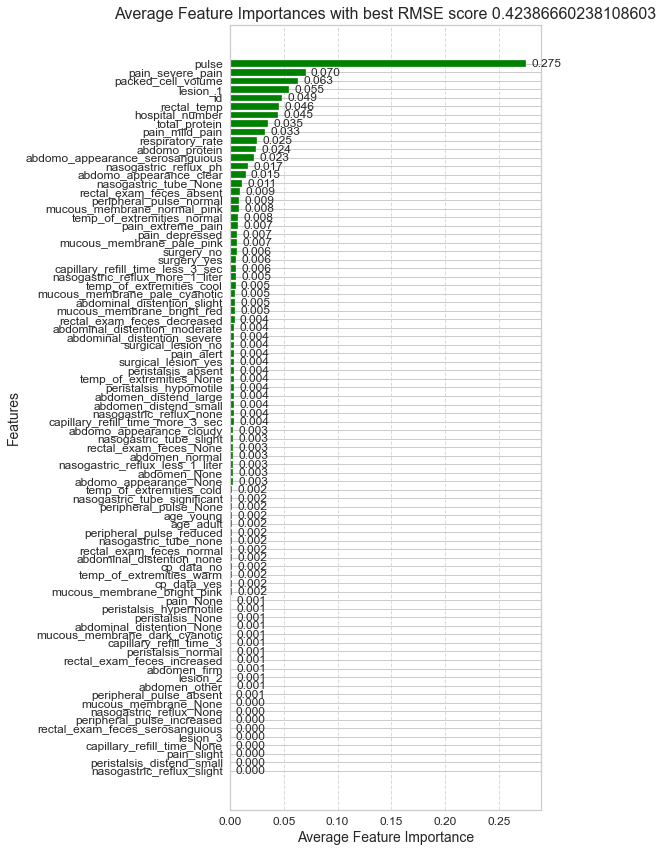

['pulse', 'pain_severe_pain', 'packed_cell_volume', 'lesion_1', 'id', 'rectal_temp', 'hospital_number', 'total_protein', 'pain_mild_pain', 'respiratory_rate', 'abdomo_protein', 'abdomo_appearance_serosanguious', 'nasogastric_reflux_ph', 'abdomo_appearance_clear', 'nasogastric_tube_None', 'rectal_exam_feces_absent', 'peripheral_pulse_normal', 'mucous_membrane_normal_pink', 'temp_of_extremities_normal', 'pain_extreme_pain', 'pain_depressed', 'mucous_membrane_pale_pink', 'surgery_no', 'surgery_yes', 'capillary_refill_time_less_3_sec', 'nasogastric_reflux_more_1_liter', 'temp_of_extremities_cool', 'mucous_membrane_pale_cyanotic', 'abdominal_distention_slight', 'mucous_membrane_bright_red', 'rectal_exam_feces_decreased', 'abdominal_distention_moderate', 'abdominal_distention_severe', 'surgical_lesion_no', 'pain_alert', 'surgical_lesion_yes', 'peristalsis_absent', 'temp_of_extremities_None', 'peristalsis_hypomotile', 'abdomen_distend_large', 'abdomen_distend_small', 'nasogastric_reflux_none'

In [6]:
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(y1,y2)))

def get_most_important_features(data_modified, data_unmodified):
    
    X_train = data_modified.drop(columns=['outcome_lived'])  
    y_train = data_modified['outcome_lived'] 
    
    X_train_pure=data_unmodified.drop(columns=['outcome_lived'])  
    y_train_pure=data_unmodified['outcome_lived'] 
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    MAE = []
    feature_importances_list = []
    
    model = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)

    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train_pure.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train_pure.iloc[val_idx]
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_val_fold)

        mae = rmse(y_val_fold, y_pred)
        MAE.append(mae)

        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_mae = np.mean(MAE)

    # Calculate average feature importances over all folds
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]

    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    list_features=[feature[0] for feature in sorted_features]
    
    feature_names, importances = zip(*sorted_features)

    plt.figure(figsize=(8, 12))
    plt.barh(range(len(feature_names)), importances, color='green')
    plt.yticks(range(len(feature_names)), feature_names, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(f'Average Feature Importances with best RMSE score {avg_mae}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on the bars
    for index, value in enumerate(importances):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return list_features, avg_mae

list_features,best_score = get_most_important_features(data, data)
print(list_features)

In [7]:
def feature_selection(data_modified,data_unmodified,list_features):
    random_seed = random.randint(0, 9999)
    
    X_train = data_modified.drop(columns=['outcome_lived'])  
    y_train = data_modified['outcome_lived'] 
    
    X_train_pure=data_unmodified.drop(columns=['outcome_lived'])  
    y_train_pure=data_unmodified['outcome_lived'] 
  
    model = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42) #reduced the estimators to make the process faster
    previous_rmse= float('inf')
    for i in range(1,len(list_features)):
        X_train_selected=X_train[list_features[:i]]
        X_train_pure_selected=X_train_pure[list_features[:i]]
        RMSE = []
        kfold = KFold(n_splits=5, shuffle=True, random_state=random_seed)
        for train_idx, val_idx in kfold.split(X_train_selected):
            X_train_fold, X_val_fold = X_train_selected.iloc[train_idx], X_train_pure_selected.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train_pure.iloc[val_idx]

            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_val_fold)

            mae = rmse(y_val_fold, y_pred)
            RMSE.append(mae)
        rmse_combined=np.mean(RMSE)
        if rmse_combined<=previous_rmse:
            print(f"score {rmse_combined} improved by adding a feature") 
        else:
            print(f"No further improvement by adding columns, consider {i} features")
            n=i
            break
        previous_rmse=rmse_combined
    return n

In [8]:
pre_anomaly_best_features=list_features[:feature_selection(data_pure,data_pure, list_features)]
print(f"Important features before removal of anomalies are {pre_anomaly_best_features}")

score 0.45499823067616835 improved by adding a feature
score 0.44655047964791506 improved by adding a feature
score 0.4410972228543911 improved by adding a feature
score 0.4189268550426156 improved by adding a feature
No further improvement by adding columns, consider 5 features
Important features before removal of anomalies are ['pulse', 'pain_severe_pain', 'packed_cell_volume', 'lesion_1', 'id']


In [9]:
main_data=data_pure.copy()

def score_check_unbiased(data_modified, data_unmodified, n_estimators):
    random_seed = random.randint(0, 9999)
    X_train = data_modified.drop(columns=['outcome_lived'])  
    y_train = data_modified['outcome_lived'] 
    
    X_train_pure=data_unmodified.drop(columns=['outcome_lived'])  
    y_train_pure=data_unmodified['outcome_lived'] 
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=7, n_jobs=-1, random_state=random_seed) 
    previous_rmse= float('inf')

    RMSE = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train_pure.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train_pure.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        mae = rmse(y_val_fold, y_pred)
        RMSE.append(mae)
    return np.mean(RMSE)

In [10]:
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

def one_class_SVM(data_pure):
    data=data_pure.copy()
    model= SGDOneClassSVM(nu=0.6016924877965066)
    model.fit(data_pure.drop(columns=['id']))

    predicted_labels = model.predict(data_pure.drop(columns=['id']))

    # Convert predicted labels to identify outliers (predicted as -1)
    outliers = predicted_labels == -1

    data['outlier_One_SVM'] = outliers

    # Print the identified outliers
    identified_outliers = data[data['outlier_One_SVM']]
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data['outlier_One_SVM']][list_features+['outcome_lived']]
    print(f"RMSE Score without the identified outliers is {score_check_unbiased(data_clean,data_pure[list_features+['outcome_lived']],250)}")
    
    return data
data=one_class_SVM(data_pure)

Number of detected Potential outliers: 0
RMSE Score without the identified outliers is 0.4239439261232027


In [11]:
def objective(trial,data_pure):
    data=data_pure.copy()
    nu = trial.suggest_float('nu', 0.01, 1.0)  #
    model = SGDOneClassSVM(nu=nu)
    model.fit(main_data.drop(columns=['id']))

    predicted_labels = model.predict(main_data.drop(columns=['id']))

    # Convert predicted labels to identify outliers (predicted as -1)
    outliers = predicted_labels == -1

    data['outlier_One_SVM'] = outliers

    # Compute the score using score_check_unbiased
    data_clean = data[~data['outlier_One_SVM']]
    data_clean=data_clean.drop(columns=["outlier_One_SVM"])
    score = score_check_unbiased(data_clean, data_pure, 25)

    return score

In [12]:
from sklearn.ensemble import IsolationForest

def isolation_forest(data_pure,data):
    model = IsolationForest(contamination=0.010650427383702971, random_state=0)

    model.fit(data_pure.drop(columns=['id']))

    # Predict the anomaly scores for each data point
    anomalies = model.predict(data_pure.drop(columns=['id']))

    outliers = anomalies == -1

    # Combine the outlier information with the original data and labels
    data['outlier_ISF'] = outliers

    # Print the identified outliers
    identified_outliers = data[data['outlier_ISF']]
    print(identified_outliers)
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data['outlier_ISF']][list_features+['outcome_lived']]
    print(data_clean.shape)
    print(f"RMSE Score after without the identified outliers is {score_check_unbiased(data_clean,data_pure[list_features+['outcome_lived']], 250)}")
    
    return data
data=isolation_forest(data_pure,data)

        id  hospital_number  rectal_temp  pulse  respiratory_rate  \
64      64           534073         37.5   66.0              13.0   
66      66          5290409         39.2  164.0              24.0   
83      83           528682         38.4   52.0              21.0   
158    158           534925         38.3  112.0              16.0   
478    478           534135         38.1   40.0              16.0   
529    529           534403         38.3   40.0              20.0   
586    586          5291719         38.3  164.0              84.0   
719    719          5290402         39.8  120.0              20.0   
793    793           529777         38.3   56.0              40.0   
812    812           528298         38.2   72.0              24.0   
856    856           530002         39.6  108.0              51.0   
895    895           534817         37.7   88.0              28.0   
1111  1111          5290482         37.6   48.0              20.0   
1214  1214           527933       

RMSE Score after without the identified outliers is 0.3214061225837631


In [13]:
from sklearn.ensemble import IsolationForest
import optuna

def objective(trial, data_pure):
    data = data_pure.copy()
    contamination = trial.suggest_float('contamination', 0.01, 0.5)  # Tune the 'contamination' hyperparameter within a range
    model = IsolationForest(contamination=contamination, random_state=0)
    model.fit(main_data.drop(columns=['id']))

    predicted_labels = model.predict(main_data.drop(columns=['id']))

    outliers = predicted_labels == -1

    data['outlier_Isolation_Forest'] = outliers

    data_clean = data[~data['outlier_Isolation_Forest']]
    data_clean = data_clean.drop(columns=["outlier_Isolation_Forest"])
    score = score_check_unbiased(data_clean, data_pure, 25)

    return score

In [14]:
from sklearn.neighbors import LocalOutlierFactor

params={'n_neighbors': 13, 'contamination': 0.01019797151100069}

def lof(data_pure,data):
    features = data_pure.drop('id', axis=1)
    lof = LocalOutlierFactor(**params)  # Adjust contamination based on your data
    anomalies = lof.fit_predict(features)  # Negative scores are outliers

    outliers = anomalies == -1

    # Combine the outlier information with the original data and labels
    data['outliers_LOF'] = outliers

    # Print the identified outliers
    identified_outliers = data[data['outliers_LOF']]
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data['outliers_LOF']][list_features+['outcome_lived']]
    print(data_clean.shape)
    print(f"RMSE Score after without the identified outliers is {score_check_unbiased(data_clean,data_pure[list_features+['outcome_lived']],250)}")
    
    return data
data=lof(data_pure,data)

Number of detected Potential outliers: 13
(1222, 85)
RMSE Score after without the identified outliers is 0.31541131183180005


In [15]:
import logging

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial, data_new, data_pure, column):
    upper_upper = data_new[column].max()
    upper_lower=data_new[column].median() + 4 * data_new[column].std()
    if upper_lower>=upper_upper:
        upper_lower=0.99*upper_upper
        
    lower_lower = data_new[column].min()
    if column=="target":
        lower_upper=data_new[column].median() - 1e-1
    else:
        lower_upper=data_new[column].median() - 2 * data_new[column].std()
    
#     lower_upper=data_new[column].median() - 1e-5

    if lower_upper<=lower_lower:
        lower_upper=lower_lower+1e-2
    
    upper_threshold = trial.suggest_float('upper_threshold',upper_lower, upper_upper)
    lower_threshold = trial.suggest_float('lower_threshold', lower_lower,lower_upper )
    
    upper_threshold = trial.suggest_float('upper_threshold',upper_lower, upper_upper)
    lower_threshold = trial.suggest_float('lower_threshold', lower_lower,lower_upper )
    
    modified_data = data_new.copy()
    modified_data[column] = modified_data[column].clip(lower_threshold, upper_threshold)
    
    mask = (data_new[column] >= lower_threshold) & (data_new[column] <= upper_threshold)

    masked_data=data_new[mask]
    score1 = score_check_unbiased(modified_data,data_pure, 20)

    if masked_data.shape[0]==0:
        return score1
    else:
        score2 = score_check_unbiased(data_new[mask],data_pure, 20)
        return min(score1,score2)

max_consecutive_best_count = 30  # Set N to the desired number of consecutive best scores to trigger early stopping

best_trial_number = 0

def early_stopping_callback(study, trial, max_consecutive_best_count):
    global best_trial_number
    
    if study.best_trial.number > best_trial_number:
        best_trial_number = study.best_trial.number
    else:
        best_trial_number = study.best_trial.number
    
    if trial.number - best_trial_number >= max_consecutive_best_count:
        print(f"Stopped Early: Same best score for {max_consecutive_best_count} consecutive trials.")
        study.stop()
def get_dataset_with_min_score(score_initial, score_clipped, score_dropped, data_new, data_clipped, data_dropped):
    scores_to_datasets = {
        score_initial: data_new,
        score_clipped: data_clipped,
        score_dropped: data_dropped
    }

    min_score = min(score_initial, score_clipped, score_dropped)
    dataset_with_min_score = scores_to_datasets[min_score]

    return dataset_with_min_score
def optimize_thresholds(data_new,data_pure, column, n_trials, max_consecutive_best_count):
    data_clipped=data_new.copy()
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, data_new, data_pure, column), n_trials=n_trials,\
                   callbacks=[lambda study, trial: early_stopping_callback(study, trial, max_consecutive_best_count)])

    best_upper_threshold = study.best_params['upper_threshold']
    best_lower_threshold = study.best_params['lower_threshold']

    print(f"Best lower & upper thresholds for column {column} ----------> ({best_lower_threshold},{best_upper_threshold})" )
    
    data_clipped[column] = data_new[column].clip(best_lower_threshold, best_upper_threshold)
    mask = (data_new[column] >= best_lower_threshold) & (data_new[column] <= best_upper_threshold)
    
    data_dropped=data_new[mask]
    
    score_initial=score_check_unbiased(data_new,data_pure,100)
    score_clipped= score_check_unbiased(data_clipped,data_pure,100)
    score_dropped=score_check_unbiased(data_dropped,data_pure,100)
    
    print(f"RMSE Score on Unchanged Data after Clipping Column {column} is {min(score_initial,score_clipped,score_dropped)}")
    return_data=get_dataset_with_min_score(score_initial, score_clipped, score_dropped, data_new, data_clipped, data_dropped)
    return return_data

In [16]:
data_new=data.copy()
print("X_predict", data_new.columns)
print("X_train", data_pure.columns)
data_new_edit=data_new.drop(data_new.columns[[87,88,89]], axis=1, inplace=True)
data_new = optimize_thresholds(data_new,data_pure, 'outcome_lived',300, max_consecutive_best_count)

X_predict Index(['id', 'hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate',
       'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
       'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3', 'surgery_no',
       'surgery_yes', 'age_adult', 'age_young', 'temp_of_extremities_None',
       'temp_of_extremities_cold', 'temp_of_extremities_cool',
       'temp_of_extremities_normal', 'temp_of_extremities_warm',
       'peripheral_pulse_None', 'peripheral_pulse_absent',
       'peripheral_pulse_increased', 'peripheral_pulse_normal',
       'peripheral_pulse_reduced', 'mucous_membrane_None',
       'mucous_membrane_bright_pink', 'mucous_membrane_bright_red',
       'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink',
       'mucous_membrane_pale_cyanotic', 'mucous_membrane_pale_pink',
       'capillary_refill_time_3', 'capillary_refill_time_None',
       'capillary_refill_time_less_3_sec', 'capillary_refill_time_more_3_sec',
       'pain_None', 'pain_alert

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.